In [1]:
import pyro.distributions as dist
from PIL import Image
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

%load_ext autoreload
%autoreload 2
# seed = 42
# torch.manual_seed(seed)

### Necessary functions

In [2]:
def PlotDistribution(distribution: pyro.distributions.Distribution, num_samples: int = 1000) -> None:
    """
    Samples from a 2D distribution and visualizes it on a plane.

    Parameters:
    - distribution: A 2D distribution object from torch.distributions.
    - num_samples: The number of samples to visualize (default is 1000).
    """
    samples = distribution.sample((num_samples,))

    samples_np = samples.numpy()

    plt.figure(figsize=(8, 6))
    plt.scatter(samples_np[:, 0], samples_np[:, 1], alpha=0.5)
    plt.title('2D Distribution Sampling')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()

### LogisticNormal

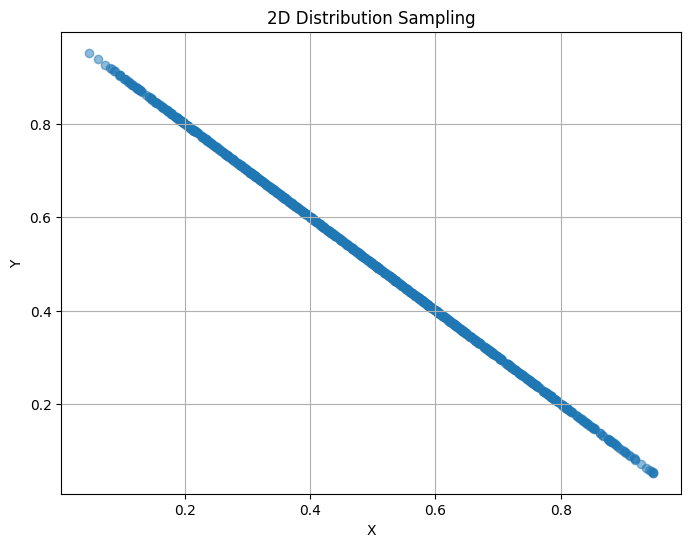

{'loc': Real(), 'scale': GreaterThan(lower_bound=0.0)}


In [3]:
loc = torch.tensor([0.0])
scale = torch.tensor([1.0])
LogisticNormal = dist.LogisticNormal(loc, scale)

PlotDistribution(LogisticNormal)

print(LogisticNormal.arg_constraints)

In [4]:
print(LogisticNormal.rsample())
print(LogisticNormal.sample())

tensor([0.6313, 0.3687])
tensor([0.3311, 0.6689])


### RelaxedBernoulli (Gumbel-Softmax)
- temperature (Tensor) – relaxation temperature

- probs (Number, Tensor) – the probability of sampling 1

- logits (Number, Tensor) – the log-odds of sampling 1

In [5]:
RelaxedBernoulli = dist.RelaxedBernoulli(temperature=torch.tensor([0.1]), probs=torch.tensor([0.1, 0.2, 0.3, 0.99]))

print(RelaxedBernoulli.rsample())
print(RelaxedBernoulli.sample())

tensor([3.5527e-09, 4.3196e-10, 4.2345e-02, 1.0000e+00])
tensor([3.5151e-08, 9.8789e-01, 1.0000e+00, 1.0000e+00])


In [6]:
RelaxedBernoulli.log_prob(torch.tensor([1.0, 1.0, 1.0, 0.5]))

tensor([ 9.8037, 10.5602, 11.0314, -5.5315])

### RelaxedOneHotCategorical (Gumbel-Softmax)
- temperature (Tensor) – relaxation temperature

- probs (Tensor) – event probabilities

- logits (Tensor) – unnormalized log probability for each event

In [7]:
RelaxedOneHotCategorical = dist.RelaxedOneHotCategorical(temperature=torch.tensor([0.1]), probs=torch.tensor([0.1, 0.2, 0.3, 0.4]))
print(RelaxedOneHotCategorical.rsample())
print(RelaxedOneHotCategorical.sample())

tensor([9.6367e-10, 8.8229e-01, 1.0651e-07, 1.1771e-01])
tensor([1.0000e+00, 4.5864e-10, 2.0317e-07, 1.9710e-06])


### [How to add new distribution](https://docs.pyro.ai/en/stable/distributions.html?#torchdistribution)
The main objective is to inherit from the `TorchDistribution` class and implement the `rsample`, `log_prob`, `event_shape`, and `batch_shape` properties.

For example, I will give the implementation of a custom normal distribution:

In [8]:
import torch
from pyro.distributions.torch_distribution import TorchDistribution
from torch.distributions import constraints
from torch.distributions.utils import _standard_normal

class CustomNormal(TorchDistribution):
    """
    Custom Normal distribution class inheriting from Pyro's TorchDistribution.

    Parameters:
    - loc (Tensor): The mean (mu) of the normal distribution.
    - scale (Tensor): The standard deviation (sigma) of the normal distribution.
    """
    
    arg_constraints = {'loc': constraints.real, 'scale': constraints.positive}
    support = constraints.real
    has_rsample = True

    def __init__(self, loc, scale, validate_args=None):
        """
        Initializes the CustomNormal distribution.
        
        Args:
        - loc (Tensor): Mean of the normal distribution.
        - scale (Tensor): Standard deviation of the normal distribution.

        The batch shape is inferred from the shape of the parameters (loc and scale), 
        meaning it defines how many independent distributions are parameterized.
        """
        self.loc = loc
        self.scale = scale
        batch_shape = torch.Size() if loc.dim() == 0 else loc.shape
        super().__init__(batch_shape, validate_args=validate_args)

    @property
    def batch_shape(self):
        """
        Returns the batch shape of the distribution.
        
        The batch shape represents the shape of independent distributions. 
        For example, if `loc` and `scale` are vectors of length 3, 
        the batch shape will be `[3]`, indicating 3 independent normal distributions.
        """
        return self.loc.shape

    @property
    def event_shape(self):
        """
        Returns the event shape of the distribution.
        
        The event shape represents the shape of each individual event. 
        For a standard Normal distribution, each event is a scalar, so `event_shape` is `[]`.
        For a multivariate Normal distribution, for example, the event shape would be the size of the vector.
        """
        return torch.Size()

    def rsample(self, sample_shape=torch.Size()):
        """
        Generates a sample from the distribution using the reparameterization trick.

        Args:
        - sample_shape (torch.Size): The shape of the generated samples.

        Samples are generated by drawing from a standard normal distribution and applying
        the affine transformation `loc + scale * eps` to obtain samples from the desired normal distribution.
        """
        shape = self._extended_shape(sample_shape)
        eps = _standard_normal(shape, dtype=self.loc.dtype, device=self.loc.device)
        return self.loc + self.scale * eps

    def log_prob(self, value):
        """
        Computes the log likelihood of a value under the normal distribution.

        Args:
        - value (Tensor): The value for which to compute the log probability.

        The log probability is calculated using the formula for the normal distribution,
        and it returns a tensor of log probabilities of the same shape as the input.
        """
        var = self.scale ** 2
        log_scale = torch.log(self.scale)
        return -((value - self.loc) ** 2) / (2 * var) - log_scale - 0.5 * torch.log(torch.tensor(2.0 * torch.pi, device=value.device))

In [9]:
loc = torch.tensor([0.0, 5.0])
scale = torch.tensor([1.0, 2.0])

MyNormal = CustomNormal(loc, scale)

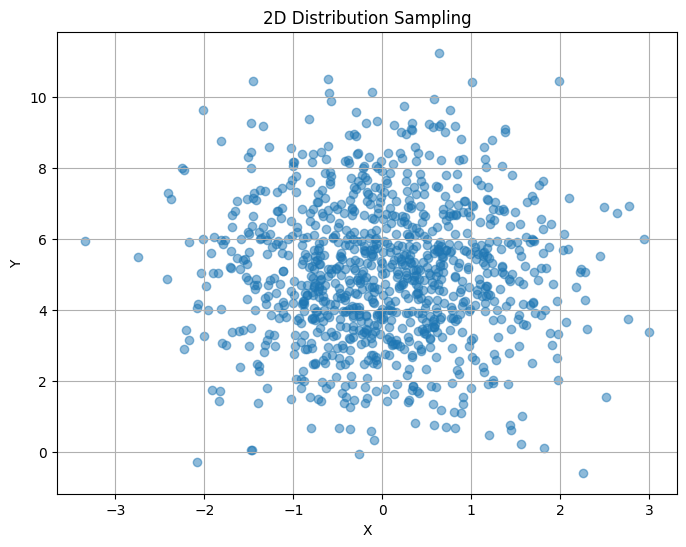

In [10]:
PlotDistribution(MyNormal)

### [Gaussian Relaxed Bernoulli](https://proceedings.mlr.press/v119/yamada20a/yamada20a.pdf)
The first method from the list was implemented and added to the library `relaxit` in `src` folder, in addition, a VAE implementation with this distribution in the latent space appeared in the `demo` folder.

What's behind the reparametrizing trick:
$$ \epsilon \sim N(0, \sigma^2), $$
$$ z = \max(0, \min(1, \mu + \epsilon)).$$
Sigma is fixed, mu is a trainable parameter.

In [12]:
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..', 'src')))
from relaxit.distributions import GaussianRelaxedBernoulli

#### Initializing distribution from the relaxit library

In [13]:
MyBernoulli = GaussianRelaxedBernoulli(loc = torch.tensor([1.0, 1.5, 5.0]), scale = torch.tensor([2.0]))

#### Let's sample from our distribution with a reparameterization trick

In [14]:
print(MyBernoulli.rsample(torch.tensor([5])), '\n')
print(f"arg_constraints = {MyBernoulli.arg_constraints}\n")
print(f"batch_shape = {MyBernoulli.batch_shape}, event_shape = {MyBernoulli.event_shape}")

tensor([[0.6148, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [0.0000, 0.0000, 1.0000],
        [0.7261, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000]]) 

arg_constraints = {'loc': Real(), 'scale': GreaterThan(lower_bound=0.0)}

batch_shape = torch.Size([3]), event_shape = torch.Size([])


#### VAE training results with Gaussian Bernoulli in latent space
The dimension of the latent space is 20, the model has been trained for 10 epochs.

To train VAE and save the results in `demo/results`, use the following code:

```python
cd demo
python vae_gaussian_bernoulli.py
```

In [15]:
Image.open('../assets/vae_results/vae_gaussian_bernoulli/vae_gaussian_bernoulli_reconstruction.png').show()
Image.open('../assets/vae_results/vae_gaussian_bernoulli/vae_gaussian_bernoulli_sample.png').show()

### [Straight-Through Bernouli ](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=62c76ca0b2790c34e85ba1cce09d47be317c7235)
The fourth method from the list was implemented and added to the library `relaxit` in `src` folder, in addition, a VAE implementation with this distribution in the latent space appeared in the `demo` folder.

$$
u \sim \text{Uniform}(0 , 1) \\
z = \mathcal{1}_{u > \sigma(a)} 
$$

In [16]:
#  Igor code
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..', 'src')))
from relaxit.distributions import StraightThroughBernoulli


In [17]:
MyStraightBernoulli = StraightThroughBernoulli(a = torch.tensor([1.0, 1.5, 5.0]))

In [20]:
print(MyStraightBernoulli.rsample(torch.tensor([5])), '\n')
print(f"arg_constraints = {MyStraightBernoulli.arg_constraints}\n")
print(f"batch_shape = {MyStraightBernoulli.batch_shape}, event_shape = {MyStraightBernoulli.event_shape}")

tensor([[1, 0, 0],
        [0, 0, 0],
        [1, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]) 

arg_constraints = {'a': Real()}

batch_shape = torch.Size([3]), event_shape = torch.Size([])


### [Hard-Concrete ]()
The six method from the list was implemented and added to the library `relaxit` in `src` folder, in addition, a VAE implementation with this distribution in the latent space appeared in the `demo` folder.

$$
u \sim \mathcal{U}[0,1] \\ 
s =\sigma( \frac{logu + log(1-u) + log\alpha}{\beta}  )  \\     
\bar{s} = s (\zeta - \gamma) + \gamma \\
z = \min ( 1 , \max (0, \bar{s})) 
$$

In [21]:
#  Igor code
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..', 'src')))
from relaxit.distributions import HardConcrete

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
MyHardConcrete = HardConcrete(alpha = torch.tensor(1.5) , beta = torch.tensor(5.8) , xi = torch.tensor(1.8), gamma = torch.tensor(-0.7))

In [32]:
print(MyHardConcrete.rsample(torch.tensor([5])), '\n')
print(f"arg_constraints = {MyHardConcrete.arg_constraints}\n")
print(f"batch_shape = {MyHardConcrete.batch_shape}, event_shape = {MyHardConcrete.event_shape}")

tensor([[0.5715],
        [0.7355],
        [0.4999],
        [0.5235],
        [0.6249]]) 

arg_constraints = {'alpha': GreaterThan(lower_bound=0.0), 'beta': GreaterThan(lower_bound=0.0), 'xi': GreaterThan(lower_bound=1.0), 'gamma': LessThan(upper_bound=0.0)}

batch_shape = torch.Size([]), event_shape = torch.Size([])


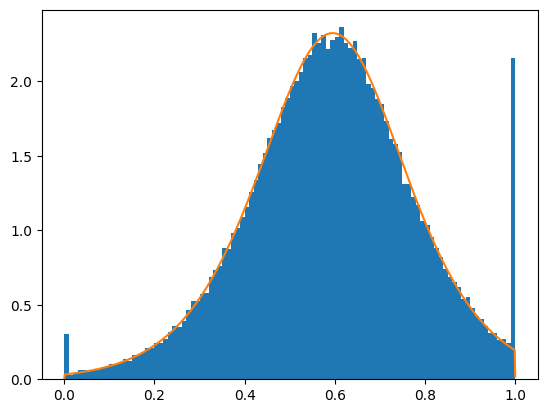

In [33]:
samples = MyHardConcrete.rsample(torch.tensor([100000]))[:,0]
x = torch.linspace(0,1,1000)
plt.hist(samples, bins=100 , density = True)
plt.plot(x , torch.exp(MyHardConcrete.log_prob(x)))
plt.show()